In [1]:
from prosit_t.inference.inference_time import get_model_times, plot_inference_time_comparison
import tensorflow as tf
import os
import wandb
from prosit_t.wandb_agent.train_utils import get_proteometools_data
from prosit_t.models import PrositTransformerV2, PrositTransformerDynamicLenDropLast
from prosit_t.eval import prosit_transformer_eval
from dlomix.models import PrositIntensityPredictor
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd

2023-11-26 20:41:53.986795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 20:41:54.095824: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 20:41:54.790433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-26 20:41:54.790502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
data_config = {
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [4]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [5]:
_, val_data = get_proteometools_data(data_config)


KeyboardInterrupt



In [ ]:
test_batch = val_data.take(1).cache()

In [ ]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-hardy-pine-74:v144"
transformer = PrositTransformerV2(
    seq_length=30,
    embedding_output_dim=64,
    num_heads=16,
    num_transformers=6,
    dense_dim_factor=4
)
transformer = prosit_transformer_eval.load_model(run,artifact_path,transformer)

In [ ]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v45"
baseline = PrositIntensityPredictor(
    seq_length=30,
    embedding_output_dim=16,
    recurrent_layers_sizes=(256, 512)
)
baseline = prosit_transformer_eval.load_model(run,baseline_path,baseline)

In [ ]:
artifact_small_path = "prosit-compms/transforming-prosit-first-pool/model-swept-monkey-124:v80"
transformer_small = PrositTransformerV2(
    seq_length=30,
    embedding_output_dim=64,
    num_heads=8,
    num_transformers=6,
    dense_dim_factor=4
)
transformer_small = prosit_transformer_eval.load_model(run,artifact_small_path,transformer_small)

In [ ]:
df = get_model_times({
    "Transformer Prosit": transformer,
    "Prosit": baseline,
    "Transformer Prosit Small": transformer_small
}, test_batch)

In [ ]:
df["color"] = ["#2c77b4", "#f77f10", "#238523"]

In [ ]:
plot_inference_time_comparison(df, "Prosit")

In [ ]:
from prosit_t.data.parquet_to_tfdataset import get_tfdatasets
_, val_data_dynamic = get_tfdatasets(data_config)

In [ ]:
from prosit_t.constants import ALPHABET_UNMOD
artifact_dynamic_path = "prosit-compms/transforming-prosit-first-pool/model-skilled-moon-891:v99"
transformer_dynamic = ProstTransformerDynamicLenDropLast(
    embedding_output_dim=64,
    num_heads=16,
    meta_embedding_dim=256,
    num_transformers=6,
    vocab_dict=ALPHABET_UNMOD
)
transformer_dynamic = prosit_transformer_eval.load_model(run,artifact_dynamic_path,transformer_dynamic)

In [15]:
tf.config.run_functions_eagerly(True)

In [16]:
val_data_dynamic_skipped = val_data_dynamic.skip(7)
dynamic_test_batch = val_data_dynamic_skipped.take(1).cache()

In [17]:
dynamic_df = get_model_times({
    "Transformer Prosit (Dynamic Output)": transformer_dynamic,
}, dynamic_test_batch)

1/1 [==============================] - 0s 56ms/step


/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"model": name, "time": inference_time}, ignore_index=True)


In [18]:
dynamic_df["color"] = ["#b42c56"]

In [19]:
df_all = pd.concat([df, dynamic_df])

In [20]:
df_all["model"] = df_all["model"].apply(lambda x: x.replace(" ", "\n"))

/cmnfs/home/l.mamisashvili/transforming-prosit/prosit_t/inference/inference_time.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


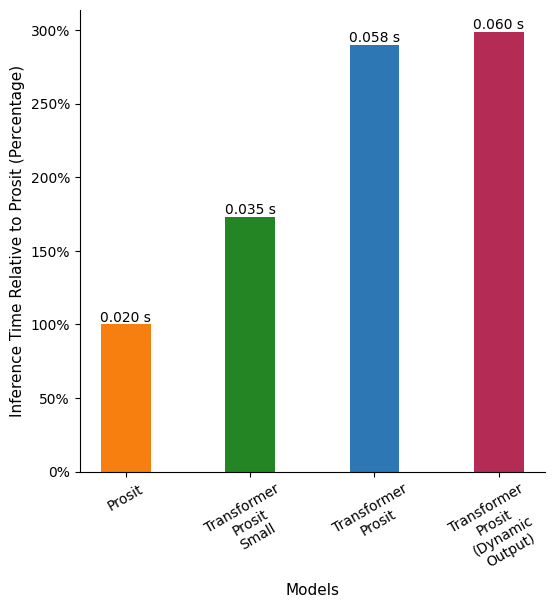

In [21]:
plot_inference_time_comparison(df_all, "Prosit")